<a href="https://colab.research.google.com/github/shreyadarban/tut/blob/main/DS_Intern_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
# Step 2: Download Apple Inc. (AAPL) stock data
stock_data = yf.download('AAPL', start='2021-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 3: Data Preprocessing - Handle missing values
stock_data = stock_data.fillna(method='ffill')


<ipython-input-3-04b97f69980e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill')


In [4]:
# Step 4: Feature Engineering

# Moving Averages (20-day, 50-day)
stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = stock_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

In [5]:
 #Step 5: Target Variable (Binary Classification - Next day price movement)
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)

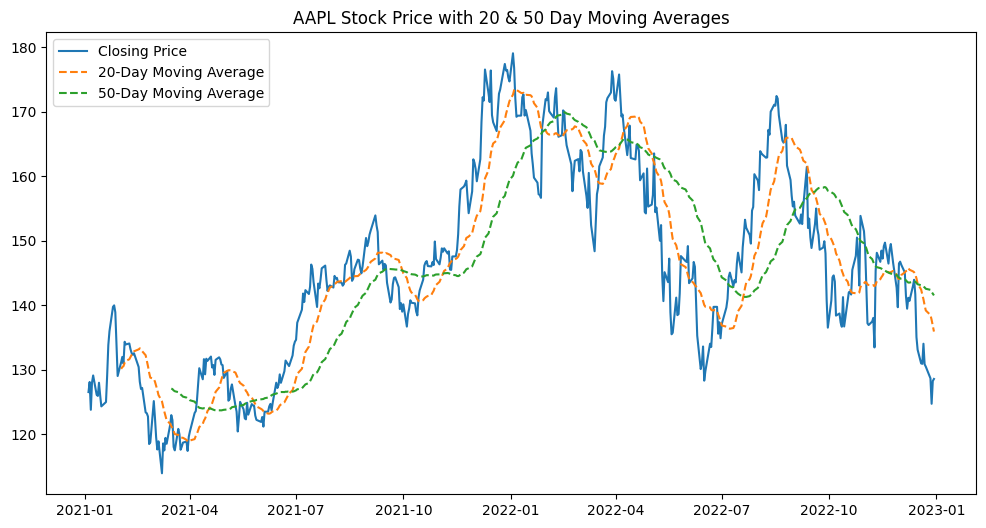

In [6]:
# Step 6: Visualizing the data (Closing Price + Moving Averages)
plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Closing Price')
plt.plot(stock_data['MA20'], label='20-Day Moving Average', linestyle='--')
plt.plot(stock_data['MA50'], label='50-Day Moving Average', linestyle='--')
plt.legend()
plt.title("AAPL Stock Price with 20 & 50 Day Moving Averages")
plt.show()

In [8]:
# Step 7: Train-Test Split
X = stock_data[['MA20', 'RSI']]  # Features: Moving Averages and RSI
y = stock_data['Target']  # Target: Next day price movement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Step 7: Train-Test Split
X = stock_data[['MA20', 'RSI']]  # Features: Moving Averages and RSI
y = stock_data['Target']  # Target: Next day price movement

# Drop rows with NaN values in features (X) and target (y)
X = X.dropna()
y = y[X.index]  # Align target with features after dropping NaNs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Model Building (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
# Step 9: Model Evaluation
y_pred = model.predict(X_test)

# Accuracy and Classification Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Backtesting a Simple Trading Strategy

# Predicting the next day's movement using the trained model
stock_data['Predicted'] = model.predict(X)

# Strategy: 1 = Buy, 0 = Sell
stock_data['Strategy_Return'] = stock_data['Predicted'] * stock_data['Close'].pct_change()

# Cumulative Returns: Strategy vs Buy & Hold
stock_data['Cumulative_Strategy_Return'] = (1 + stock_data['Strategy_Return']).cumprod() - 1
stock_data['Cumulative_Buy_Hold_Return'] = (1 + stock_data['Close'].pct_change()).cumprod() - 1

# Plotting Strategy's Performance vs Buy & Hold
plt.figure(figsize=(12,6))
plt.plot(stock_data['Cumulative_Strategy_Return'], label='Strategy Cumulative Return')
plt.plot(stock_data['Cumulative_Buy_Hold_Return'], label='Buy & Hold Cumulative Return')
plt.legend()
plt.title("Strategy Performance vs Buy & Hold")
plt.show()

# Step 11: Performance Metrics (Cumulative Return, Max Drawdown, Sharpe Ratio)
cumulative_return = stock_data['Cumulative_Strategy_Return'].iloc[-1]
max_drawdown = (stock_data['Cumulative_Strategy_Return'].cummax() - stock_data['Cumulative_Strategy_Return']).max()

# Sharpe ratio calculation (simplified)
strategy_returns = stock_data['Strategy_Return'].dropna()
sharpe_ratio = strategy_returns.mean() / strategy_returns.std()

print("Cumulative Return:", cumulative_return)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)

# Step 12: Parameter Optimization (Optional)
param_grid = {'C': [0.1, 1, 10], 'max_iter': [100, 200, 300]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Step 13: Save the stock data to CSV
stock_data.to_csv('AAPL_stock_data_with_features.csv')

Accuracy: 0.4639175257731959
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.35      0.40        49
           1       0.47      0.58      0.52        48

    accuracy                           0.46        97
   macro avg       0.46      0.47      0.46        97
weighted avg       0.46      0.46      0.46        97



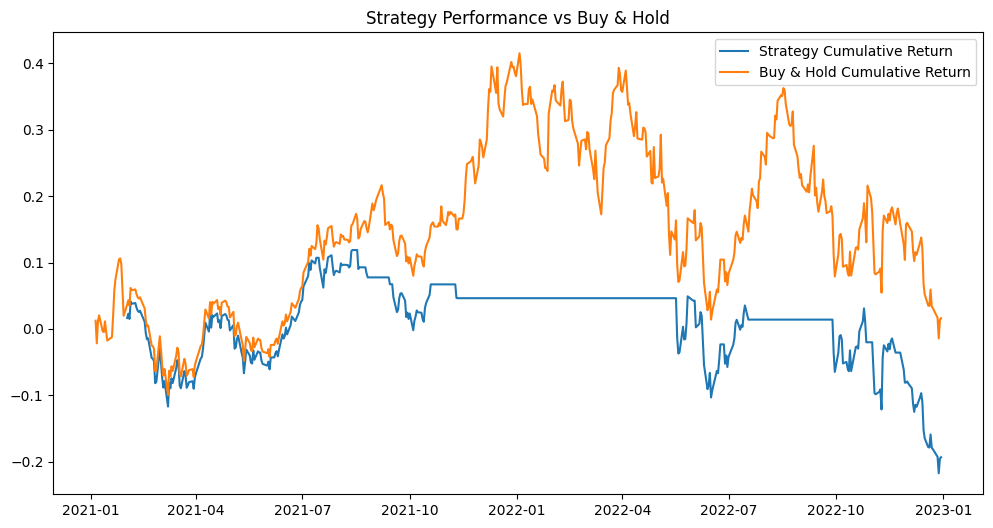

In [16]:
# Step 10: Backtesting a Simple Trading Strategy

# Predicting the next day's movement using the trained model
# Use the same X that was used for training (which has NaNs removed)
stock_data['Predicted'] = np.nan  # Initialize the column with NaN
stock_data.loc[X.index, 'Predicted'] = model.predict(X) # Assign predictions to corresponding rows in original dataframe

# Strategy: 1 = Buy, 0 = Sell
# Ensure both operands are Series by using .squeeze() if necessary
stock_data['Strategy_Return'] = stock_data['Predicted'].squeeze() * stock_data['Close'].pct_change().squeeze()

# Cumulative Returns: Strategy vs Buy & Hold
stock_data['Cumulative_Strategy_Return'] = (1 + stock_data['Strategy_Return']).cumprod() - 1
stock_data['Cumulative_Buy_Hold_Return'] = (1 + stock_data['Close'].pct_change()).cumprod() - 1

# Plotting Strategy's Performance vs Buy & Hold
plt.figure(figsize=(12,6))
plt.plot(stock_data['Cumulative_Strategy_Return'], label='Strategy Cumulative Return')
plt.plot(stock_data['Cumulative_Buy_Hold_Return'], label='Buy & Hold Cumulative Return')
plt.legend()
plt.title("Strategy Performance vs Buy & Hold")
plt.show()

In [17]:
# Step 11: Performance Metrics (Cumulative Return, Max Drawdown, Sharpe Ratio)
cumulative_return = stock_data['Cumulative_Strategy_Return'].iloc[-1]
max_drawdown = (stock_data['Cumulative_Strategy_Return'].cummax() - stock_data['Cumulative_Strategy_Return']).max()

# Sharpe ratio calculation (simplified)
strategy_returns = stock_data['Strategy_Return'].dropna()
sharpe_ratio = strategy_returns.mean() / strategy_returns.std()

print("Cumulative Return:", cumulative_return)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)


Cumulative Return: -0.1932166885480272
Max Drawdown: 0.3361879488204559
Sharpe Ratio: -0.025097707886026062


In [18]:

# Step 12: Parameter Optimization (Optional)
param_grid = {'C': [0.1, 1, 10], 'max_iter': [100, 200, 300]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.1, 'max_iter': 100}


In [19]:
# Step 13: Save the stock data to CSV
stock_data.to_csv('AAPL_stock_data_with_features.csv')